In [50]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from PIL import Image

In [51]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    return image

In [52]:
# Load and preprocess image
# image_path = "real_A.png" 
# image_path = "real_B.png" 
# image_path = "fake_B.png" 
image_path = "fake_A.png"  # Replace with your image file
input_tensor = preprocess_image(image_path)

In [53]:
print(input_tensor.shape)

torch.Size([1, 3, 256, 256])


In [54]:
print(input_tensor.min(), input_tensor.max())

tensor(0.0392) tensor(0.8941)


In [55]:
# Load the pretrained MobileNetV2 model from a saved checkpoint
def load_model(model_path):
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(in_features=1280, out_features=2)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Replace with your saved model path
model_path = "/home/taha/Taha26/All_Experiments/facepad/best_models_256x256/OULU_NPU_Train_Test_256x256/OULUNPU_best_model.pth"
# model_path = "/home/taha/Taha26/All_Experiments/cyclegan_fpad_SRA_TRB_lsgan_unet128/adv_train/OULUNPU_GAN/OULUNPU_FB.pth"
model = load_model(model_path)

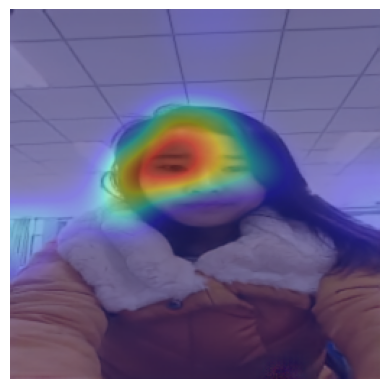

In [56]:
# Set CNN layers to evaluation mode
model.eval()

target_layer = "features.18" 

# Grad-CAM generation code
cam_extractor = GradCAM(model, target_layer)

output = model(input_tensor)


# Get predicted class
predicted_class = output.argmax(dim=-1).item()

# Extract Grad-CAM
activation_map = cam_extractor(predicted_class, output)[0] 

input_image_pil = to_pil_image(input_tensor.squeeze(0))

# Overlay Grad-CAM on the original image
result = overlay_mask(input_image_pil, to_pil_image(activation_map, mode='F'), alpha=0.6)

# Show the result
plt.imshow(result)
plt.axis("off")
# plt.title(f"Grad-CAM for class {predicted_class}")
plt.savefig("grad_cam_result.png", bbox_inches="tight", pad_inches=0, dpi=100)
plt.show()